# Experiment: Convergence of NTK for RNN

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from kernels.utils import clone_grads, paramdot
from models import SimpleRNNClassifier
import torch

## Generate data

In [2]:
import math
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len
val_num = 100
for i in range(num_records):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)


## Compute Infinite NTK

In [3]:
from kernels import RNTK,TNTK
from kernels.utils import clone_grads, paramdot, VErf3, VDerErf3
varw = 1
varu = 2
varb = 0.2
varv = 1
avgpool = True

inps = X[:3]
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]
inpcov = np.moveaxis(inpcov, 1, 2)

inf_ntk = RNTK(inpcov, VErf3, VDerErf3, varw, varu, varb, varv, avgpool=avgpool)

## Compare finite NTK and infinite NTK

In [4]:
def simrnn_ntk(inputseqs, width, phi, varw=1, varu=1, varb=0, varv=1, seed=None, avgpool=False, debug=False):
    if seed is not None:
        torch.manual_seed(seed)
    indim = inputseqs[0].shape[1]
    rnn = SimpleRNNClassifier(indim, width, nonlin=phi,
                              varw=varw, varu=varu, varb=varb, varv=varv,
                              avgpool=avgpool, debug=debug)
    grads = []
    sgrads = []
    states = []
    hs = []
    for seq in inputseqs:
        out = rnn(seq.unsqueeze(0))
        out.backward()
        grads.append(clone_grads(rnn))
        if debug:
            # shape time x dim_s
            sgrads.append(clone_sgrads(rnn))
            states.append(clone_states(rnn))
            hs.append(clone_hs(rnn))
        rnn.zero_grad()
        
    batchsize = len(inputseqs)
    
    ntk = torch.zeros(batchsize, batchsize)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = paramdot(grads[i], grads[j])
    
    if not debug:
        return dict(ntk=ntk)
    
    dscov = torch.zeros(batchsize, batchsize).tolist()
    scov = torch.zeros(batchsize, batchsize).tolist()
    hhcov = torch.zeros(batchsize, batchsize).tolist()
    for i in range(batchsize):
        for j in range(0, i+1):
            dscov[i][j] = (sgrads[i] @ sgrads[j].T).numpy()
            dscov[j][i] = dscov[i][j].T
            scov[i][j] = (states[i] @ states[j].T).numpy() / states[i].shape[-1]
            scov[j][i] = scov[i][j].T
            hhcov[i][j] = (hs[i] @ hs[j].T).numpy() / hs[i].shape[-1]
            hhcov[j][i] = hhcov[i][j].T
    return dict(ntk=ntk, dscov=np.block(dscov), scov=np.block(scov), hhcov=np.block(hhcov))

def NTK_theory_vs_sim(inpseqs, infntk, varw, varu, varb, avgpool,
                      nonlin=torch.erf,
                      log2widthmin=6, log2widthmax=15, nseeds=10):
    if isinstance(inpseqs, np.ndarray):
        inpseqs = torch.from_numpy(inpseqs).float()
    widths = 2**np.arange(log2widthmin, log2widthmax)
    mysimcovs = {}
    for width in tqdm(widths):
        mysimcovs[width] = np.stack([
            simrnn_ntk(inpseqs, width,
                       nonlin, varw, varu, varb,
                       seed=seed, avgpool=avgpool, debug=False)['ntk']
            for seed in range(nseeds)])
    frobs = []
    infntknorm = np.linalg.norm(infntk)
    for width in widths:
        _frobs = np.sum((mysimcovs[width] - infntk)**2,
                        axis=(1, 2)) / infntknorm**2
        for f in _frobs:
            frobs.append(dict(
                relfrob=np.sqrt(f),
                width=width
            ))
    return pd.DataFrame(frobs)

In [5]:
frob_df = NTK_theory_vs_sim(inps, inf_ntk, varw, varu, varb,
                           avgpool=True, log2widthmax=14, nseeds=100)

100%|████████████████████████████████████████████| 8/8 [35:41<00:00, 267.71s/it]


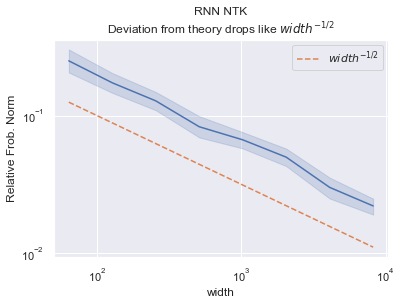

In [6]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'RNN NTK\nDeviation from theory drops like $width^{-1/2}$')

In [7]:
frob_df.to_pickle('output/rnn_ap_ntk.frob')